In [1]:
import rclpy
from pi3hat_moteus_int_msgs.msg import JointsCommand,JointsStates
import rosbag2_api.read_bag as rb
import rosbag2_api.save_csv_file as csv_wrt
import os 
from matplotlib import pyplot as plt
import numpy as np
from statistics import mean,stdev

import mpld3
mpld3.enable_notebook()
# %matplotlib widget

ModuleNotFoundError: No module named 'rclpy'

In [2]:
exp_name = 'test_2023_09_05__16_19_05_00'
new_folder_ = 'best_data/'

####################################################################################################
####################################################################################################

##### configurazione ottimizzazione #####
# name_folder = new_folder_ + 'Test_jump_17_10_2023_019_q0_5_ff'
# name_folder = new_folder_ + 'Test_jump_18_10_2023_019_q0_23' 
name_folder = new_folder_ + 'Test_jump_18_10_2023_019_q0_22_ff'

##### configurazione panino #####
# name_folder = new_folder_ + 'Test_jump_18_10_2023_019_q0_bimbi_15'

##### configurazione ottimizzazione ##### vecchio test 
## con il terminale dentro il il workspace 
## cambiare la parte dei messaggi 
# name_folder = new_folder_ + 'Test_jump_19_09_2023_006_ground' 
# commenta in JointStates.msg current 
# compila colcon build 
# chiudi code 
# source  /opt/ros/humble/setup.bash 
# . install/local_setup.bash 
# code .
# puoi lanciare questo file 


In [3]:
## useful param 
line_width = 3
font_size = 14
cond_cmd_big = 8.0
cond_cmd_big = 10.0
alpha = 0.5
label_i = [r'Hip ', r'Knee'] 

In [4]:
act_path  = os.path.join(os.path.expanduser("~"),"Documents")
mul_env_path = os.path.join(os.path.expanduser("~"),"Documents","softlegjump_ws")
stt_bag_path = os.path.join(mul_env_path,name_folder+'_test_bag',"stt_"+exp_name,"stt_"+exp_name+"_0.db3")
cmd_bag_path = os.path.join(mul_env_path,name_folder+'_test_bag',"cmd_"+exp_name,"cmd_"+exp_name+"_0.db3")
per_bag_path = os.path.join(mul_env_path,name_folder+'_test_bag',"per_"+exp_name,"per_"+exp_name+"_0.db3")

print(stt_bag_path)
print(os.path.exists(stt_bag_path), os.path.exists(cmd_bag_path), os.path.exists(per_bag_path))


/home/mulinexopc/Documents/softlegjump_ws/best_data/Test_jump_18_10_2023_019_q0_22_ff_test_bag/stt_test_2023_09_05__16_19_05_00/stt_test_2023_09_05__16_19_05_00_0.db3
True True True


In [5]:
stt_msgs = rb.read_from_all_topics(stt_bag_path)
stt_msg = stt_msgs[0][3]

jnt_num = len(stt_msg[0].name)
stt_num = len(stt_msgs[0][2])

msr_times = np.full(stt_num,0.0)
# for i in range(stt_num):
#     print(stt_msg[i].header.stamp.sec)
msr_pos = np.full((stt_num,jnt_num),0.0)
msr_vel = np.full((stt_num,jnt_num),0.0)
msr_eff = np.full((stt_num,jnt_num),0.0)
msr_temp = np.full((stt_num,jnt_num),0.0)
msr_curr = np.full((stt_num,jnt_num),0.0)
msr_count = np.full(stt_num,0.0)
msr_sec_end_pos = np.full((stt_num,jnt_num),0.0)

for i in range(stt_num):
    # print(stt_msg[i].header.stamp.sec,stt_msg[i].header.stamp.nanosec)
    msr_times[i] = stt_msg[i].header.stamp.sec + stt_msg[i].header.stamp.nanosec/pow(10,9)
    for j in range(jnt_num):
        msr_pos[i][j] = stt_msg[i].position[j]
        msr_vel[i][j] = stt_msg[i].velocity[j]
        msr_eff[i][j] = stt_msg[i].effort[j]
        if name_folder == new_folder_ + 'Test_jump_19_09_2023_006_ground':
            pass
        else:
            msr_curr[i][j] = stt_msg[i].current[j]
            msr_temp[i][j] = stt_msg[i].temperature[j]
        # msr_sec_end_pos[i][j] = stt_msg[i].sec_enc_pos[j]

In [6]:
cmd_msgs = rb.read_from_all_topics(cmd_bag_path)
cmd_msg = cmd_msgs[0][3]

jnt_num = len(cmd_msg[0].name)
cmd_num = len(cmd_msgs[0][2])

cmd_times = cmd_msgs[0][2]
# for i in range(stt_num):
#     print(stt_msg[i].header.stamp.sec)
cmd_pos = np.full((cmd_num,jnt_num),0.0)
cmd_vel = np.full((cmd_num,jnt_num),0.0)
cmd_eff = np.full((cmd_num,jnt_num),0.0)
# cmd_kp = np.full((cmd_num,jnt_num),0.0)

for i in range(cmd_num):
    # print(stt_msg[i].header.stamp.sec,stt_msg[i].header.stamp.nanosec)
    cmd_times[i] = cmd_times[i]/pow(10, 9) #  cmd_msg[i].header.stamp.sec + cmd_msg[i].header.stamp.nanosec/pow(10,9)
    for j in range(jnt_num):
        cmd_pos[i][j] = cmd_msg[i].position[j]
        cmd_vel[i][j] = cmd_msg[i].velocity[j]
        if name_folder == new_folder_ + 'Test_jump_19_09_2023_006_ground':
            pass
        else:
            cmd_eff[i][j] = cmd_msg[i].effort[j]
        # msr_temp[i][j] = stt_msg[i].temperature[j]

In [7]:
print('Real Time Task:\n\n\tHoming 5 sec\n\tTask sec', np.around(-msr_times[0] + msr_times[-1] - 5, decimals=4))
print('dt:\n\tMeas: {}\n\tSend {} [sec]'.format(np.around((-msr_times[0] + msr_times[-1])/len(msr_times), decimals=4), 
                                                np.around((cmd_times[-1] - cmd_times[0])/len(cmd_times), decimals=4) ))

Real Time Task:

	Homing 5 sec
	Task sec 9.916
dt:
	Meas: 0.0017
	Send 0.0016 [sec]


In [8]:
import pandas
plt_bag_path = os.path.join(mul_env_path, name_folder + '_test_bag')

csv_dic = {"time": msr_times, "count" : msr_count, "msr_pos": msr_pos[:,0], "msr_vel": msr_vel[:,0], "msr_eff": msr_eff[:,0], "msr_temp":msr_temp[:,0],}
df = pandas.DataFrame(csv_dic)
# df.to_csv("msr_"+exp_name+"_c2.csv")
df.to_csv( plt_bag_path + "/msr_c1.csv")

csv_dic = {"time": msr_times, "count" : msr_count, "msr_pos": msr_pos[:,1], "msr_vel": msr_vel[:,1], "msr_eff": msr_eff[:,1], "msr_temp":msr_temp[:,1]}
df = pandas.DataFrame(csv_dic)
# df.to_csv("msr_"+exp_name+"_c3.csv")
df.to_csv( plt_bag_path + "/msr_c2.csv")

csv_dic = {"time": cmd_times,  "cmd_eff": cmd_eff[:,0]}
df = pandas.DataFrame(csv_dic)
# df.to_csv("cmd_"+exp_name+"_c2.csv")
df.to_csv( plt_bag_path + "/cmd_c1.csv")

csv_dic = {"time": cmd_times, "cmd_eff": cmd_eff[:,1]}
df = pandas.DataFrame(csv_dic)
# df.to_csv("cmd_"+exp_name+"_c3.csv")
df.to_csv( plt_bag_path + "/cmd_c2.csv")


In [9]:
cmd_times = np.array(cmd_times) - np.array(cmd_times)[0]
msr_times = np.array(msr_times) - np.array(msr_times)[0]
start_time = 0

if name_folder == new_folder_ + 'Test_jump_18_10_2023_019_q0_23':
    ################################## config saroj cut time ##################################
    # name_folder = new_folder_ + 'Test_jump_18_10_2023_019_q0_23' 
    cond_cmd = np.logical_and(cmd_times > 13.15, cmd_times < 14.95)
    cond_msr = np.logical_and(msr_times > 13.15, msr_times < 14.95)
    lim_x_sup = 1.75
    end_time = 0.45
elif    name_folder == new_folder_ + 'Test_jump_18_10_2023_019_q0_22_ff':
    ################################## config saroj cut time ##################################
    # name_folder = new_folder_ + 'Test_jump_18_10_2023_019_q0_22_ff'
    cond_cmd = np.logical_and(cmd_times > 13.15, cmd_times < 14.95)
    cond_msr = np.logical_and(msr_times > 13.15, msr_times < 14.95)
    lim_x_sup = 1.75
    end_time = 0.45
    
elif name_folder == new_folder_ + 'Test_jump_17_10_2023_019_q0_5_ff':
    ################################## config saroj cut time  ##################################
    ## name_folder = new_folder_ + 'Test_jump_17_10_2023_019_q0_5_ff' 
    cond_cmd = np.logical_and(cmd_times > 8.0, cmd_times < 10.0)
    cond_msr = np.logical_and(msr_times > 8.0, msr_times < 10.0) 
    end_time = 0.4
    lim_x_sup = 1.5
elif name_folder == new_folder_ + 'Test_jump_18_10_2023_019_q0_bimbi_15':
    ################################## config panino cut time  ##################################
    ## name_folder = new_folder_ + 'Test_jump_18_10_2023_019_q0_bimbi_15'
    cond_cmd = np.logical_and(cmd_times > 8.0, cmd_times < 10.1)
    cond_msr = np.logical_and(msr_times > 8.0, msr_times < 10.1) 
    end_time = 0.3 
    lim_x_sup = 1.0
elif name_folder == new_folder_ + 'Test_jump_19_09_2023_006_ground':
    ## name_folder = new_folder_ + 'Test_jump_19_09_2023_006_ground' 
    cond_cmd = np.logical_and(cmd_times > 13.0, cmd_times < 15.5)
    cond_msr = np.logical_and(msr_times > 13.0, msr_times < 15.5) 
    end_time = 0.4
    lim_x_sup = 2.2
else:
    assert ('Select a proper name')


index_cmd = np.where(cond_cmd)[0]
index_msr = np.where(cond_msr)[0]

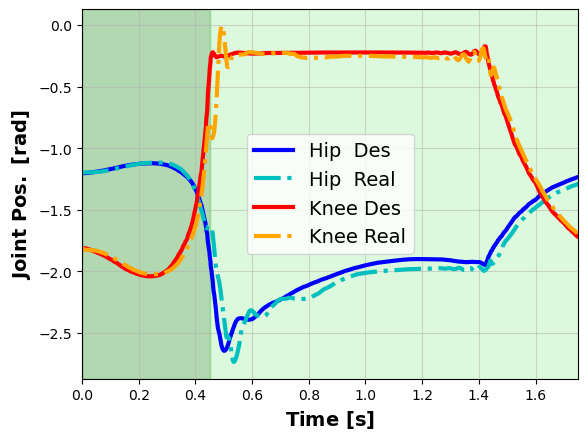

In [10]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Your existing code

fig, ax = plt.subplots()
plt_bag_path = os.path.join(mul_env_path, name_folder + '_test_bag', "JNT_TOT" + "_pos_plot.svg")
plt.plot(cmd_times[index_cmd] - cmd_times[index_cmd[0]], cmd_pos[index_cmd, 0], linewidth=line_width, color='b', label=label_i[0] + r' Des')
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_pos[index_msr, 0], linewidth=line_width, color='c', linestyle='-.', label=label_i[0] + r' Real')

plt.plot(cmd_times[index_cmd] - cmd_times[index_cmd[0]], cmd_pos[index_cmd, 1], linewidth=line_width, color='r', label=label_i[1] + r' Des')
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_pos[index_msr, 1], linewidth=line_width, color=[1.0, 165/255, 0.0], linestyle='-.', label=label_i[1] + r' Real')

plt.xlabel(r'$\mathbf{Time\,\, [s]}$', fontsize=font_size)
plt.ylabel(r'$\mathbf{Joint\,\, Pos.\,\, [rad]}$', fontsize=font_size)

plt.legend(fontsize=font_size, loc='best')
plt.grid(alpha=alpha)

# Create patches for the colored regions
ax.add_patch(patches.Rectangle((start_time, plt.gca().get_ylim()[0]), end_time - start_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='green', alpha=0.3))
ax.add_patch(patches.Rectangle((end_time, plt.gca().get_ylim()[0]), plt.gca().get_xlim()[1] - end_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='lightgreen', alpha=0.3))
ax.set_xlim([0,lim_x_sup])  
plt.savefig(plt_bag_path)
plt.show()

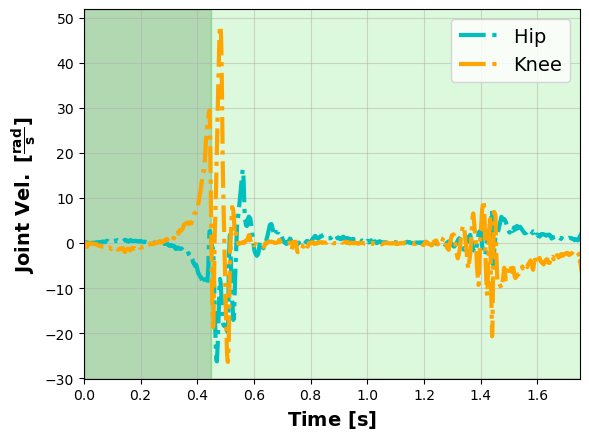

In [11]:

fig, ax = plt.subplots()
plt_bag_path = os.path.join(mul_env_path,name_folder+'_test_bag',"JNT_TOT" + "_vel_plot.svg")
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_vel[index_msr,0],linewidth=line_width, color= 'c', linestyle = '-.', label=label_i[0])
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_vel[index_msr,1],linewidth=line_width, color= [1.0,165/255,0.0], linestyle = '-.', label=label_i[1])

plt.xlabel(r'$\mathbf{Time\,\, [s]}$', fontsize=font_size)  # Increase font size for time label
plt.ylabel(r'$\mathbf{Joint\,\, Vel.\,\, [\frac{rad}{s}]}$', fontsize=font_size)  # Increase font size for radians label

plt.legend(fontsize=font_size, loc='best') 
plt.grid(alpha=alpha)  
plt.savefig(plt_bag_path)

# Create patches for the colored regions
ax.add_patch(patches.Rectangle((start_time, plt.gca().get_ylim()[0]), end_time - start_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='green', alpha=0.3))
ax.add_patch(patches.Rectangle((end_time, plt.gca().get_ylim()[0]), plt.gca().get_xlim()[1] - end_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='lightgreen', alpha=0.3))
ax.set_xlim([0,lim_x_sup])
plt.savefig(plt_bag_path)

plt.show() 

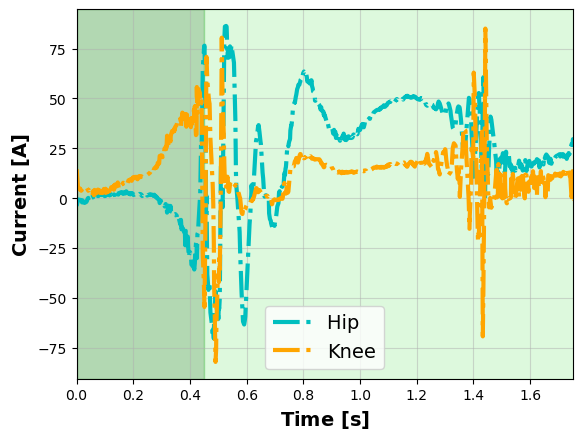

In [12]:
fig, ax = plt.subplots()
plt_bag_path = os.path.join(mul_env_path,name_folder+'_test_bag',"JNT_TOT"+ str(i + 1) +"_plot_cur_2.svg")
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_curr[index_msr,0],linewidth=line_width, color='c', linestyle = '-.', label=label_i[0])
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_curr[index_msr,1],linewidth=line_width, color=[1.0,165/255,0.0], linestyle = '-.', label=label_i[1])

plt.xlabel(r'$\mathbf{Time\,\, [s]}$', fontsize=font_size)  # Increase font size for time label
plt.ylabel(r'$\mathbf{Current\,\, [A]}$', fontsize=font_size)  # Increase font size for radians label

plt.legend(fontsize=font_size) 
plt.grid(alpha=alpha)  
plt.savefig(plt_bag_path)

# Create patches for the colored regions
ax.add_patch(patches.Rectangle((start_time, plt.gca().get_ylim()[0]), end_time - start_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='green', alpha=0.3))
ax.add_patch(patches.Rectangle((end_time, plt.gca().get_ylim()[0]), plt.gca().get_xlim()[1] - end_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='lightgreen', alpha=0.3))
ax.set_xlim([0,lim_x_sup])
plt.savefig(plt_bag_path)

plt.show() 

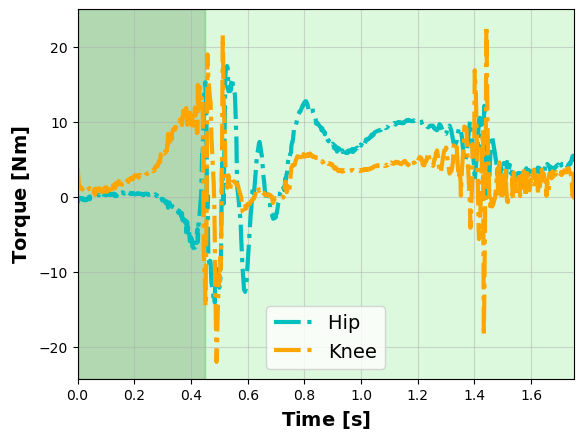

In [13]:
fig, ax = plt.subplots()
plt_bag_path = os.path.join(mul_env_path,name_folder+'_test_bag',"JNT_TOT" + "_tor_plot.svg")
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_eff[index_msr,0],linewidth=line_width, color= 'c', linestyle = '-.', label=label_i[0])
plt.plot(msr_times[index_msr] - msr_times[index_msr[0]], msr_eff[index_msr,1],linewidth=line_width, color= [1.0,165/255,0.0], linestyle = '-.', label=label_i[1])

plt.xlabel(r'$\mathbf{Time\,\, [s]}$', fontsize=font_size)  # Increase font size for time label
plt.ylabel(r'$\mathbf{Torque\,\, [Nm]}$', fontsize=font_size)  # Increase font size for radians label

plt.legend(fontsize=font_size, loc='best') 
plt.grid(alpha=alpha)  
plt.savefig(plt_bag_path)

# Create patches for the colored regions
ax.add_patch(patches.Rectangle((start_time, plt.gca().get_ylim()[0]), end_time - start_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='green', alpha=0.3))
ax.add_patch(patches.Rectangle((end_time, plt.gca().get_ylim()[0]), plt.gca().get_xlim()[1] - end_time, plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0], color='lightgreen', alpha=0.3))
ax.set_xlim([0,lim_x_sup])
plt.savefig(plt_bag_path)

plt.show() 